Run the HardwareSetup script to get access to ```hardware_setup``` and ```alazar_DAC```

In [1]:
%run HardwareSetup.ipynb

Start the atsaverage status window

In [2]:
import atsaverage.gui
status_window = atsaverage.gui.ThreadedStatusWindow(alazar_DAC.card)
status_window.start()

Load the example pulse

In [3]:
from qctoolkit.serialization import Serializer, FilesystemBackend

nested_loop_pulse = Serializer(FilesystemBackend('./serialized_pulses')).deserialize('nested_loops')

parameters=dict(N_T=10, N_T_rep=5, N_rep=17, T=192, T_start=2*192, T_step=160)

assert nested_loop_pulse.measurement_names == {'M'}

alazar_DAC.register_mask_for_channel('M', 0)

In [4]:
operations = [atsaverage.operations.Downsample()]
operations[0].maskID = 'M'
operations[0].identifier = 'DSM'

alazar_DAC.register_operations('nested_loops', operations)

# store raw data for later inspection
alazar_DAC.config.rawDataMask = atsaverage.atsaverage.ChannelMask(1)

In [6]:
from qctoolkit.pulses.sequencing import Sequencer

seq = Sequencer()
seq.push(nested_loop_pulse, 
         parameters=parameters, channel_mapping=dict(A='TABOR_A', marker='TABOR_A_MARKER'))
g = seq.build()

Multiply all voltages of ```TABOR_A``` with 0.5

In [7]:
hardware_setup.rm_channel('TABOR_A')
hardware_setup.set_channel('TABOR_A', PlaybackChannel(tchannelpair_AB, 0, voltage_transformation=lambda x: 0.5*x))
hardware_setup.register_program('nested_loops', g)

In [8]:
hardware_setup.arm_program('nested_loops')


            Scanline configuration:
                Total record size:   4352
                Sample rate:         100000000
                Total time:          4.352e-05 s

                Buffer size:         4352
                Time per buffer:     4.352e-05 s
                Number of buffers:   1

                Recording Channels:  A
                Store raw data:      True
            


In [9]:
tchannelpair_AB.run_current_program()

In [10]:
results = alazar_DAC.card.extractNextScanline()

In [12]:
raw = results.rawData

array([33736, 34248, 34652, ..., 30788, 30860, 30904], dtype=uint16)

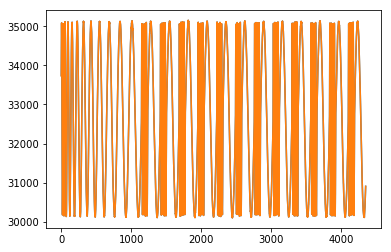

In [14]:
from matplotlib import pyplot as plt
plt.plot(raw)
plt.show()